# Creacion de sistema de recomendacion para una muestra de los datos

En este notebook se realiza la implementación de un sistema de recomendación inicial tomando una pequeña muestra del conjunto de datos. Esto se realiza con el fin de mostrar la viabilidad de la construcción de un sistema de recomendación (resultado presentado en el anteproyecto de la materia)

In [1]:
%matplotlib notebook

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
### Realizo carga de los datos de muestra
### Para descargar los datos para realizar la ejecucion de este notebook, se pueden dirigir
### al link de google drive: https://drive.google.com/drive/folders/1Obo2lWQBfDTinmSyPAddNiOzT2BXZnvP?usp=sharing
df = pd.read_csv('data/datos_muestra.csv')
df.head(4)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,15536614,R36RXVL3XIZFH7,B003UJC2QI,207971309,Love Or Money/Love Sweet Love,Music,5.0,0.0,0.0,N,N,Great Pop Single,Love Or Money by Billy Fury is a great song ! ...,2015-08-31
1,US,15536614,R3OP2H2S0RIBHP,B0010XRHZC,695461680,BILLY FURY Halfway To Paradise / Cross My Hear...,Music,5.0,0.0,0.0,N,N,Great Pop Single,Halfway To Paradise by Billy Fury is a great s...,2015-08-31
2,US,23767443,R37RFLBIGKHA9L,B00QW8Q3LE,303959370,Sounds Like Nashville / Various,Music,4.0,1.0,1.0,N,N,Country Music Sure Comes In All Types!,"There's some really top Country Music here, al...",2015-08-31
3,US,15536614,R22J06WAPZF335,B005XQQ09Q,79239346,BEE GEES/One/45rpm record,Music,5.0,0.0,0.0,N,N,Great Pop Single,One by The Bee Gees was released in 1989 and c...,2015-08-31


In [5]:
print(f"Cantidad de usuarios: {len(df['customer_id'].unique())}")
print(f"Cantidad de productos: {len(df['product_id'].unique())}")

Cantidad de usuarios: 2808
Cantidad de productos: 284721


<IPython.core.display.Javascript object>


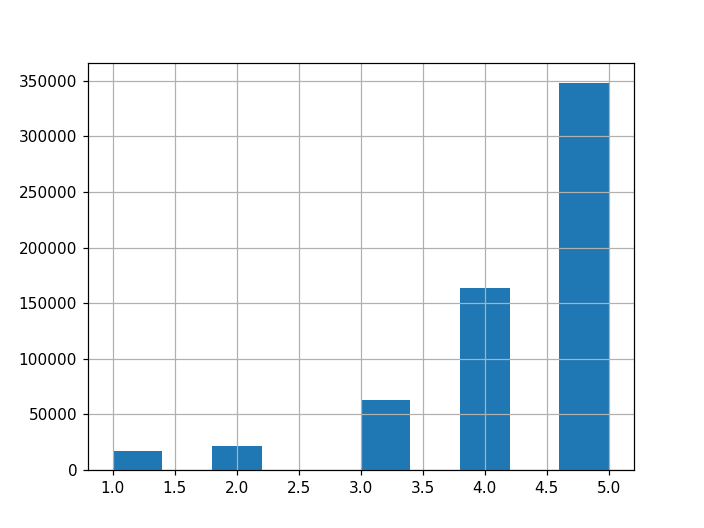

In [6]:
### Histograma de los ratings
df['star_rating'].hist()

In [7]:
### dejo un DF con la informacion para crear el sistema de recomendacion
df_s = df[['customer_id','product_id','star_rating']].rename(columns = {'customer_id':'userID','product_id':'itemID','star_rating':'rating'})

In [8]:
### Paquetes para crear el modelo con Surprise
from surprise import SVD
from surprise import Dataset
from surprise import dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [9]:
### funcion del error cuadratico medio
def mse(y, y_pred):
    return np.mean((y - y_pred)**2)

In [10]:
### Codigo para convertir un dataframe de pandas a un Dataset de Surprise

class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userID'], df['itemID'], df['rating'])]
        self.reader=reader

        
reader = Reader(line_format='user item rating', rating_scale = (1,5))
data = MyDataset(df_s, reader)

In [11]:
### Realizamos la particion en train y test del conjunto de datos
trainset, testset = train_test_split(data, test_size=.25, random_state = 42)

In [12]:
### obtengo el promedio de los rating en el conjunto de entrenamiento para crear la
### prediccion base, es decir, en el conjunto de prueba la predicicon de rating
### corresponde al promedio de todos los ratings en el conjunto de entrenamiento
suma = 0
cuenta = 0
for (uid, iid, rating) in trainset.all_ratings():
    suma = suma + rating
    cuenta = cuenta + 1
    
promedio = suma/cuenta

In [13]:
### Asigno al conjunto de prueba el promedio como prediccion y obtengo el valor de la metrica
df_test = pd.DataFrame(testset, columns =['userID','itemID','rating'])
df_test['preds'] = promedio

error_test = mse(df_test['rating'], df_test['preds'])
print(f'Error del modelo baseline {error_test}')

Error del modelo baseline 0.9634101989533559


In [14]:
### Entrenamiento del sistema de  recomendacion
algo = SVD()
algo.fit(trainset)

### Prediccion y obtencion del MSE
predictions = algo.test(testset)
print('Prediccion en el conjunto de prueba con el modelo entrenado')
accuracy.mse(predictions)

Prediccion en el conjunto de prueba con el modelo entrenado
MSE: 0.6985


0.69850067807048599

Vemos entonces que el modelo construido con la libreria Surprise es mejor que el modelo baseline. Por lo tanto es un resultado prometedor para profundizar en un modelo de sistema de recomendación